In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [2]:
class CNN_FMnist(nn.Module):
    def __init__(self):
        super(CNN_FMnist, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 16),
            nn.ReLU(),
        )

        self.z_mean = nn.Linear(16, 2)
        self.z_log_var = nn.Linear(16, 2)

        self.decoder = nn.Sequential(
            nn.Linear(2, 64*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = FashionMNIST(root='~/data', train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
testset = FashionMNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(testset))
print(len(train_dl), len(test_dl))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:14<00:00, 1874247.51it/s]


Extracting /home/khoidh/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/khoidh/data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 162009.32it/s]


Extracting /home/khoidh/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/khoidh/data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:04<00:00, 1033050.87it/s]


Extracting /home/khoidh/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/khoidh/data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 17218721.68it/s]

Extracting /home/khoidh/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/khoidh/data/FashionMNIST/raw

60000 10000
469 79


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_FMnist().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 10

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.23it/s]


Epoch: 0 - TrainRecLoss: 54.56299990021598 - ValidRecLoss: 31.748209723943397
Epoch: 0 - TrainDivLoss: 2.8885084407161803 - ValidDivLoss: 4.9404380713837055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.67it/s]


Epoch: 1 - TrainRecLoss: 30.28265902228447 - ValidRecLoss: 29.192300434353985
Epoch: 1 - TrainDivLoss: 4.928254210872691 - ValidDivLoss: 5.036988228182249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.47it/s]


Epoch: 2 - TrainRecLoss: 28.795407980489834 - ValidRecLoss: 28.38871948628486
Epoch: 2 - TrainDivLoss: 4.996428751996331 - ValidDivLoss: 4.825242628025103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.05it/s]


Epoch: 3 - TrainRecLoss: 27.968185164526837 - ValidRecLoss: 27.740671688997292
Epoch: 3 - TrainDivLoss: 5.008412100867168 - ValidDivLoss: 4.958296480058115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.72it/s]


Epoch: 4 - TrainRecLoss: 27.45687164274106 - ValidRecLoss: 27.31210204015804
Epoch: 4 - TrainDivLoss: 4.980528857916403 - ValidDivLoss: 5.031296398066267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.00it/s]


Epoch: 5 - TrainRecLoss: 27.109840218192225 - ValidRecLoss: 27.11280962787097
Epoch: 5 - TrainDivLoss: 4.96698802976466 - ValidDivLoss: 4.8345268587522865


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.59it/s]


Epoch: 6 - TrainRecLoss: 26.791423817941627 - ValidRecLoss: 26.917481168915955
Epoch: 6 - TrainDivLoss: 4.93572153160567 - ValidDivLoss: 4.7950769798665105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.09it/s]


Epoch: 7 - TrainRecLoss: 26.52332214810955 - ValidRecLoss: 26.619387711150736
Epoch: 7 - TrainDivLoss: 4.92251061071465 - ValidDivLoss: 4.831234388713595


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.06it/s]


Epoch: 8 - TrainRecLoss: 26.299399682962054 - ValidRecLoss: 26.68355866927135
Epoch: 8 - TrainDivLoss: 4.917258971281397 - ValidDivLoss: 4.8161228397224525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 68.51it/s]

Epoch: 9 - TrainRecLoss: 26.12769074023151 - ValidRecLoss: 26.096886236456378
Epoch: 9 - TrainDivLoss: 4.899346100496077 - ValidDivLoss: 4.906432375123229


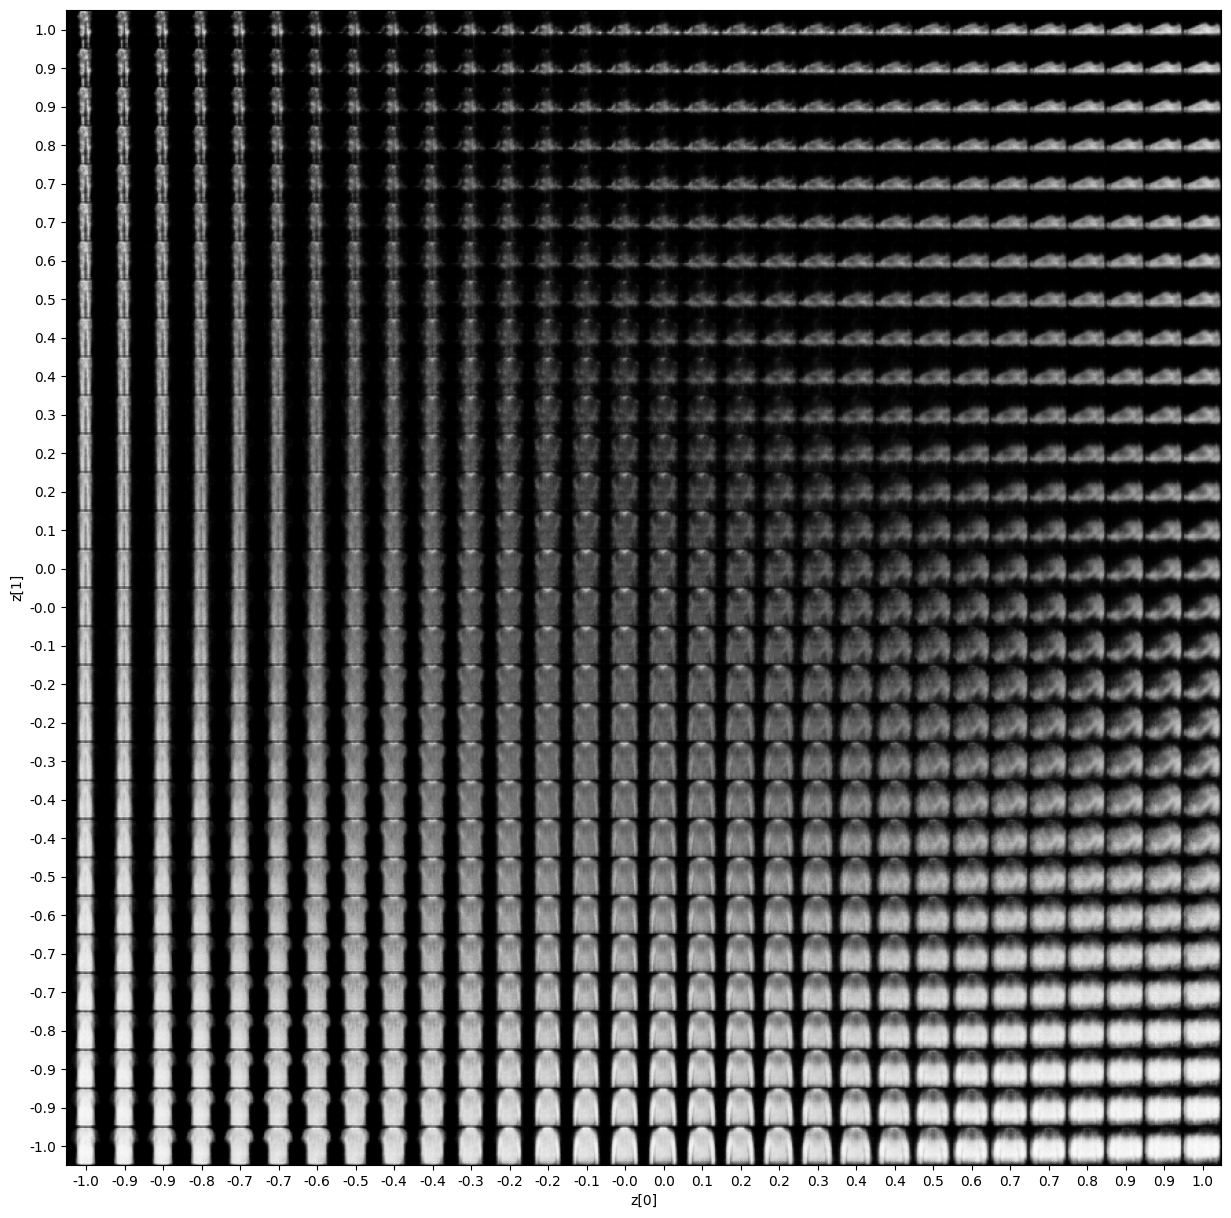

In [8]:
digit_size = 28
scale = 1.0
n = 30
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).to(device, dtype=torch.float)
        x_decoded = model.decoder(z_sample)
        digit = x_decoded[0].detach().cpu().numpy()
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x) 
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()

In [9]:
def interpolate(autoencoder, x_1, x_2, n=20):
    z_1 = autoencoder.get_latent(x_1)[0]
    z_2 = autoencoder.get_latent(x_2)[0]
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    fig, ax = plt.subplots(figsize=(15, 2))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

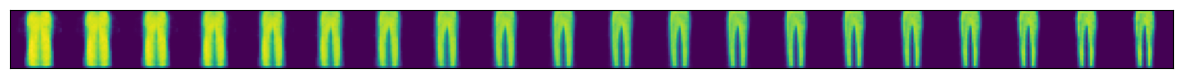

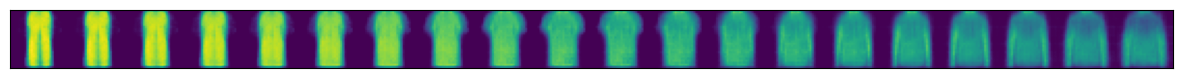

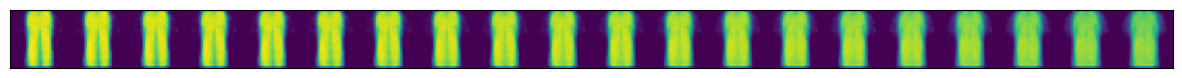

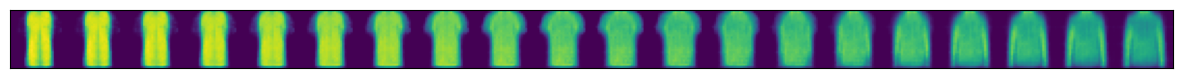

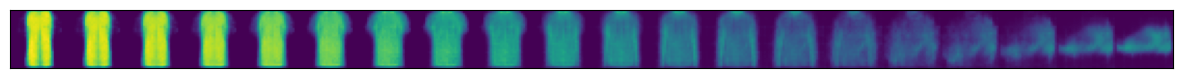

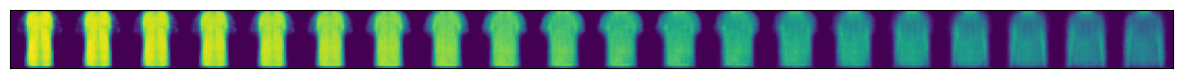

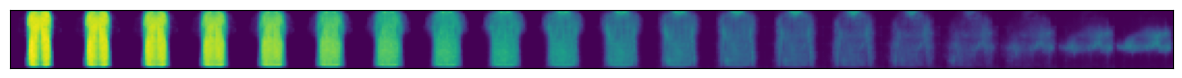

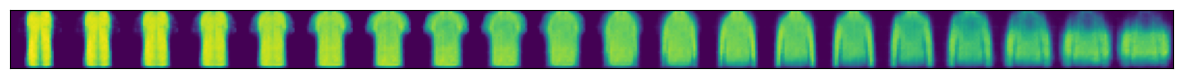

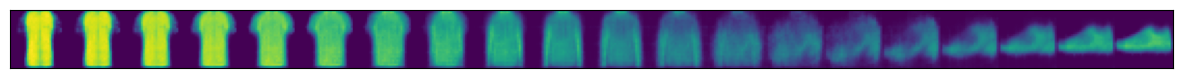

In [10]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_dl))
    x_1 = x[y == 0][1].to(device).unsqueeze(0)
    
    for idx in range(1, 10):
        x_2 = x[y == idx][1].to(device).unsqueeze(0)
        interpolate(model, x_1, x_2, n=20)